In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime as dt
import seaborn as sns
from scipy import stats

Preporcessing 

In [245]:
#Open relevant datasets
movie = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
IMDB_title = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/IMDB/title.basics.tsv', sep='\t')
character = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/MovieSummaries/character.metadata.tsv', sep='\t', header=None)



/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_87178/1571144117.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDB_title = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/IMDB/title.basics.tsv', sep='\t')


In [246]:
# Adding column names to movie dataframe
movie_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"]
movie.columns = movie_columns
character_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
character.columns = character_columns

In [247]:
#Inspect how many NaN values in the Movie release date column
NaN_before = movie['Movie release date'].isnull().sum()
print('NaN values in Movie release date column:', NaN_before)


NaN values in Movie release date column: 6902


In [248]:
# We will use the IMDB_title dataframe to extract the movie release year to fill in the NaN values in the Movie release date column
# 1) Remove columns where StartYear is = \N
IMDB_title = IMDB_title[IMDB_title['startYear'] != '\\N']
#2) Leave only row where titleType is movie since we are only interested in movies
IMDB_title = IMDB_title[IMDB_title['titleType'] == 'movie']
# 3) Convert StartYear to pd.datetime
IMDB_title['startYear'] = pd.to_datetime(IMDB_title['startYear'], format='%Y-%m-%d', errors='coerce')
# 4) Extract only the year from the startYear column
IMDB_title['startYear'] = IMDB_title['startYear'].dt.year
# 5) Doing the same for the movie dataframe
movie['Movie release date'] = pd.to_datetime(movie['Movie release date'], format='%Y-%m-%d', errors='coerce')
# 6) Extract only the year from the Movie release date column
movie['Movie release year'] = movie['Movie release date'].dt.year


In [249]:
# Merging step
# 1) rename the column 'Movie name' to 'primaryTitle' in the IMDB_title dataframe
IMDB_title = IMDB_title.rename(columns={'primaryTitle': 'Movie name'})

# We want to fill the NaN values in the Movie release year column with the values in StartYear column in IMDB_title dataframe
# 2) Merge the two dataframes on the Movie name column
movie = movie.merge(IMDB_title[['Movie name', 'startYear', 'genres']], on='Movie name', how='left')
# 3) Fill the NaN values in the Movie release year column with the values in the startYear column
movie['Movie release year'] = movie['Movie release year'].fillna(movie['startYear'])
# 4) Drop the startYear column
movie = movie.drop(columns=['startYear'])
#) Rename genres to IMDB_genres
movie = movie.rename(columns={'genres': 'IMDB_genres'})



In [250]:
# Check the number of NaN values in the Movie release year column after filling the NaN values
NaN_after = movie['Movie release year'].isnull().sum()
print('NaN values in Movie release year column:', NaN_after)
print('We filled', NaN_before - NaN_after, 'NaN values in the Movie release year column')

NaN values in Movie release year column: 3535
We filled 3367 NaN values in the Movie release year column


In [251]:
def extract_genres(genre_string):
    # Convert the string representation of dictionary to an actual dictionary
    genre_dict = eval(genre_string)
    # Extract genre names and join them into a single string separated by commas
    return ', '.join(genre_dict.values())

In [252]:
#Apply the function to the Movie genres column 
movie.loc[:, 'Movie genres'] = movie['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)


In [253]:
# Now we want to merge character dataframe with movie dataframe
# Use the key that is common Wikipedia movie ID, just get the actor gender from the character dataframe

character_movie = character.merge(movie[['Wikipedia movie ID', 'Movie release year', 'Movie genres', 'Movie box office revenue', 'Movie runtime', 'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 'IMDB_genres']], on='Wikipedia movie ID', how='left')


# Drop NaN values whe Actor gender is NaN
character_movie = character_movie.loc[character_movie['Actor gender'].notnull()]



Genre analysis

In [254]:
# To restrict the genres we have we create a list of the main genres in the film industry
main_genres = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Historical', 'Horror', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'Western', 'Erotic', 'Musical', 'Gangster Film', 'War', 'Crime Drama']
# We create a new column called Main genres and fill it with the main genres and compare them to the genres in the Movie genres column and take the intersection of the two lists
movie['Main genres'] = movie['Movie genres'].apply(lambda x: list(set(x.split(', ')).intersection(main_genres)))

#We do same for character_movie dataframe
character_movie['Main genres'] = character_movie['Movie genres'].apply(lambda x: list(set(x.split(', ')).intersection(main_genres)))

The data is therefore divided into three parts that are interesting to analyze:

* Before the feminist movement: from 1914 to 1963.
* During the feminist movement: from 1963 to 1980.
* After the feminist movement: from 1980 to 2012.

In [255]:
#Partition the data into 3 dataframes based on the Movie release year
# movie from 1914 to 1963 :
movie_1914_1963 = movie[(movie['Movie release year'] >= 1914) & (movie['Movie release year'] <= 1963)]
explode_movie_1914_1963 = movie_1914_1963.explode('Main genres')
# movie from 1964 to 1980 :
movie_1964_1980 = movie[(movie['Movie release year'] >= 1964) & (movie['Movie release year'] <= 1980)]
explode_movie_1964_1980 = movie_1964_1980.explode('Main genres')
# movie from 1981 to 2012 :
movie_1981_2012 = movie[(movie['Movie release year'] >= 1981) & (movie['Movie release year'] <= 2012)]
explode_movie_1981_2012 = movie_1981_2012.explode('Main genres')


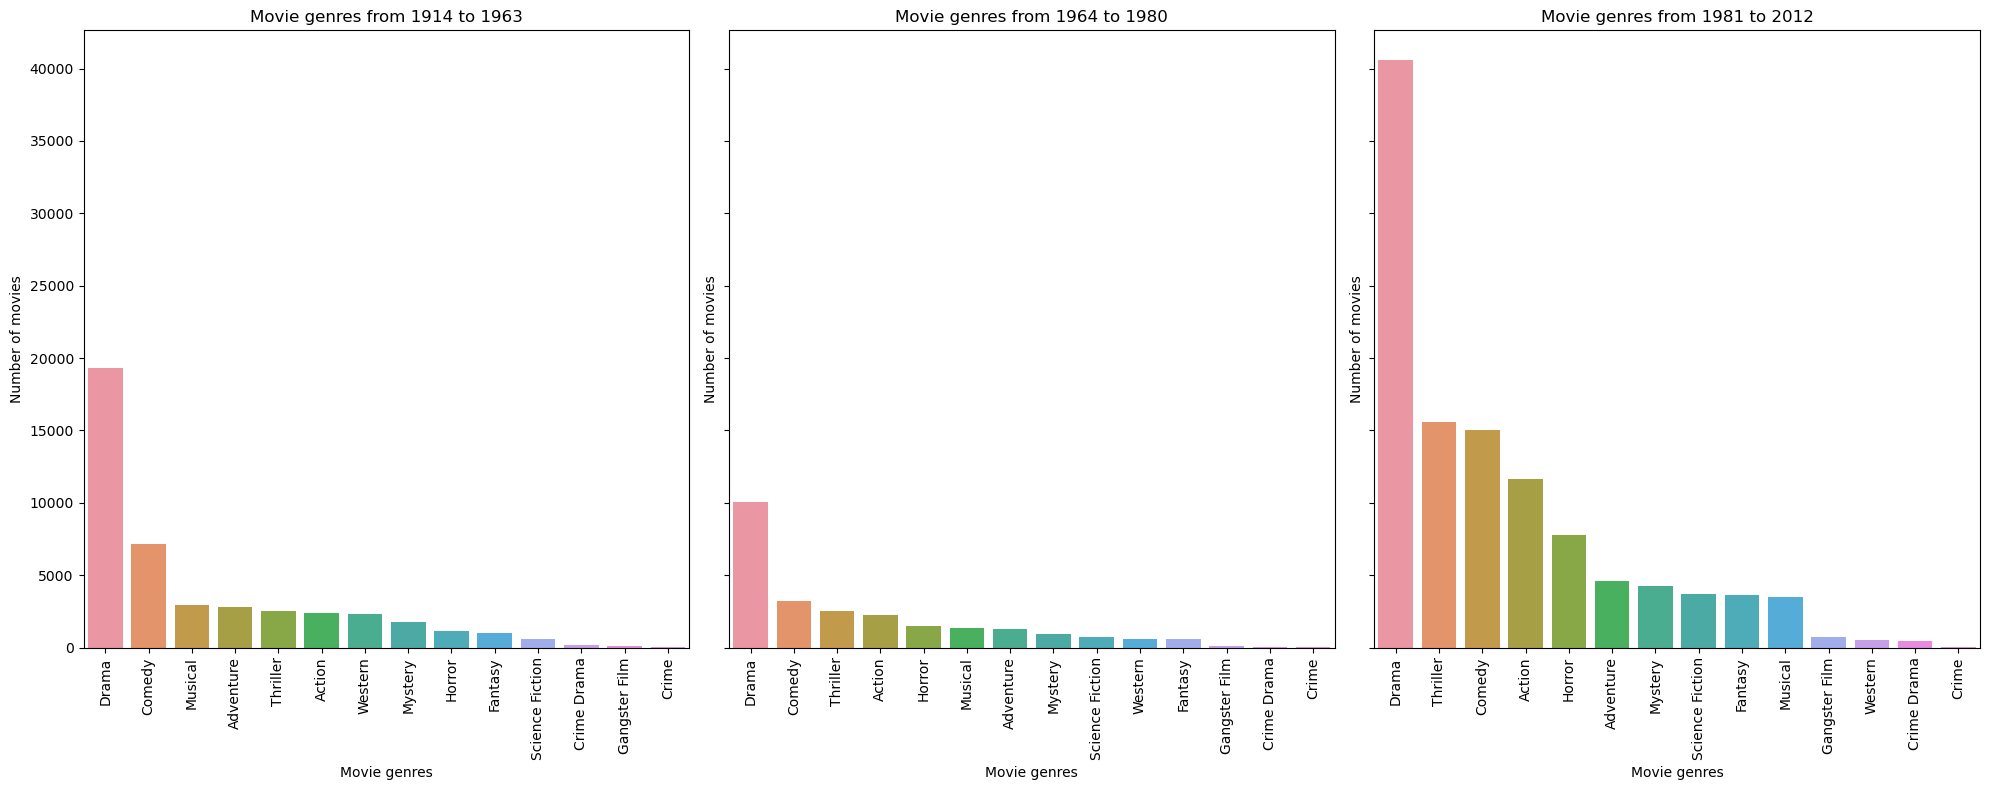

In [256]:
# Putting dataframes in a list
dataframes = [explode_movie_1914_1963, explode_movie_1964_1980, explode_movie_1981_2012]
#Putting titles in a list
titles = ['Movie genres from 1914 to 1963', 'Movie genres from 1964 to 1980', 'Movie genres from 1981 to 2012']

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for ax, df, title in zip(axes, dataframes, titles):
    sns.countplot(x='Main genres', data=df, ax=ax, order=df['Main genres'].value_counts().index)
    ax.set_title(title)
    ax.set_xlabel('Movie genres')
    ax.set_ylabel('Number of movies')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels if necessary

plt.tight_layout()
plt.show()


In [257]:
# Print the drama proportion for each time period using explode_movie_1914_1963, explode_movie_1964_1980, explode_movie_1981_2012
print('Drama proportion from 1914 to 1963:', explode_movie_1914_1963['Main genres'].value_counts(normalize=True)['Drama'])
print('Drama proportion from 1964 to 1980:', explode_movie_1964_1980['Main genres'].value_counts(normalize=True)['Drama'])
print('Drama proportion from 1981 to 2012:', explode_movie_1981_2012['Main genres'].value_counts(normalize=True)['Drama'])




Drama proportion from 1914 to 1963: 0.4356899776881296
Drama proportion from 1964 to 1980: 0.39891990628598656
Drama proportion from 1981 to 2012: 0.3627973877230129


In [258]:
# Now let us focus on the character_movie dataframe, we will filter to do more in depth analysis
#Let us group by wikipedia movie ID and create a new dataframe where at least we have 3 female actors i.e Actor gender = 'F'
#Step 1 : filter female actors
female_actors_df = character_movie.loc[character_movie['Actor gender'] == 'F']

#Step 2 : Group by movie Wikipedia ID
grouped = female_actors_df.groupby('Wikipedia movie ID')



# Step 3: Count female actors
count_female_actors = grouped.size()


# Step 4: Filter groups with at least 3 female actors
movies_with_3_females = count_female_actors[count_female_actors >= 3].index

# Step 5: Create final DataFrame
female_actors_final = character_movie[character_movie['Wikipedia movie ID'].isin(movies_with_3_females)]


In [259]:
# Change 1010 to 2010 in the Movie release date column
female_actors_final['Movie release date'] = female_actors_final['Movie release date'].str.replace('1010', '2010')



/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_87178/2484023759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_actors_final['Movie release date'] = female_actors_final['Movie release date'].str.replace('1010', '2010')


In [260]:
# Like before partition the data into 3 dataframes based on the Movie release year
female_actors_final['Movie release date'] = female_actors_final['Movie release date'].str[:4]
female_actors_final['Movie release date'] = pd.to_datetime(female_actors_final['Movie release date'], errors='coerce')
female_actors_final['Movie release date']  = female_actors_final['Movie release date'].dt.year

#Partition the data into 3 dataframes based on the Movie release year
# movie from 1914 to 1963 :
female_1914_1963 = female_actors_final[(female_actors_final['Movie release date'] >= 1914) & (female_actors_final['Movie release date'] <= 1963)]
explode_female_1914_1963 = female_1914_1963.explode('Main genres')
# movie from 1964 to 1980 :
female_1964_1980 = female_actors_final[(female_actors_final['Movie release date'] >= 1964) & (female_actors_final['Movie release date'] <= 1980)]
explode_female_1964_1980 = female_1964_1980.explode('Main genres')
# movie from 1981 to 2012 :
female_1981_2012 = female_actors_final[(female_actors_final['Movie release date'] >= 1981) & (female_actors_final['Movie release date'] <= 2012)]
explode_female_1981_2012 = female_1981_2012.explode('Main genres')


/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_87178/3382883825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_actors_final['Movie release date'] = female_actors_final['Movie release date'].str[:4]
/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_87178/3382883825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_actors_final['Movie release date'] = pd.to_datetime(female_actors_final['Movie release date'], errors='coerce')
/var/folders/18/5mg94qls17908xtk_njkwfnr000

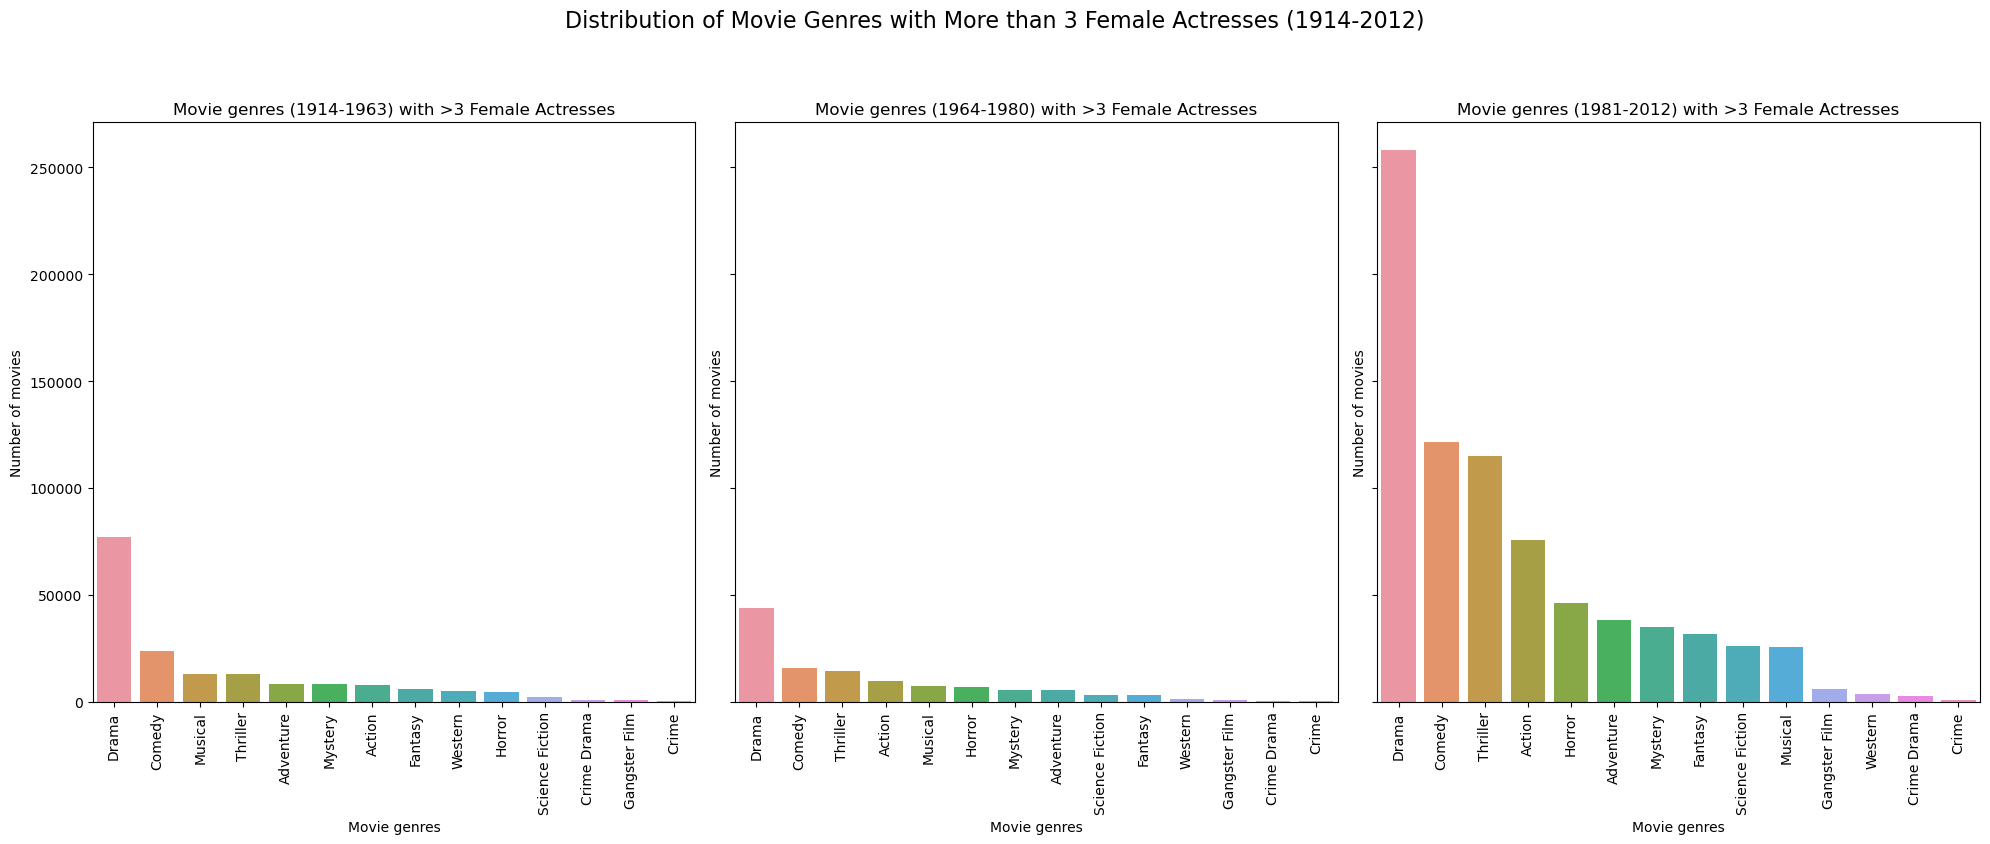

In [261]:
#Put the dataframes in a list
dataframes = [explode_female_1914_1963, explode_female_1964_1980, explode_female_1981_2012]

#Put the titles in a list
titles = ['Movie genres (1914-1963) with >3 Female Actresses', 
          'Movie genres (1964-1980) with >3 Female Actresses', 
          'Movie genres (1981-2012) with >3 Female Actresses']

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for ax, df, title in zip(axes, dataframes, titles):
    sns.countplot(x='Main genres', data=df, ax=ax, order=df['Main genres'].value_counts().index)
    ax.set_title(title)
    ax.set_xlabel('Movie genres')
    ax.set_ylabel('Number of movies')
    ax.tick_params(axis='x', rotation=90) # Rotate x-axis labels

# Adding a main title to the figure
plt.suptitle('Distribution of Movie Genres with More than 3 Female Actresses (1914-2012)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


In [262]:
# Open txt file that contains the plot summaries
with open('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/MovieSummaries/plot_summaries.txt', 'r') as f:
    plot_summaries = f.readlines()

    
# Each movie has a number and then its plot seperated by \t 
# We want to extract the movie number and the plot and put them in a dataframe
# One column for movie number and one column for plot
movie_number = []
plot = []
for line in plot_summaries:
    movie_number.append(line.split('\t')[0])
    plot.append(line.split('\t')[1].replace('\n', ''))

# Create a dataframe with the movie number and plot
plot_summaries = pd.DataFrame({'Movie number': movie_number, 'Plot': plot})

Let's do some analyis on the plots of the movies

In [263]:
# We do a left merge on the movie dataframe and the plot_summaries dataframe on the Movie number column
#first rename the Movie number column to Wikipedia movie ID
plot_summaries = plot_summaries.rename(columns={'Movie number': 'Wikipedia movie ID'})
plot_summaries['Wikipedia movie ID'] = plot_summaries['Wikipedia movie ID'].astype(int)


# We do a left merge on the movie dataframe and the plot_summaries dataframe on the Movie number column
movie_plot = movie.merge(plot_summaries, on='Wikipedia movie ID', how='left')    

# Remove rows where the plot is NaN
movie_plot = movie_plot[movie_plot['Plot'].notna()]

#
movie_plot['Plot'] = movie_plot['Plot'].str.lower()

#Each word in the plot is separated by a space so we split the plot into a list of words
movie_plot['Plot'] = movie_plot['Plot'].str.split(' ')







In [264]:
#Partition the data into 3 dataframes based on the Movie release year
# movie from 1914 to 1963 :
movie_1914_1963 = movie_plot[(movie_plot['Movie release year'] >= 1914) & (movie_plot['Movie release year'] <= 1963)]
explode_movie_1914_1963 = movie_1914_1963.explode('Plot')
# movie from 1964 to 1980 :
movie_1964_1980 = movie_plot[(movie_plot['Movie release year'] >= 1964) & (movie_plot['Movie release year'] <= 1980)]
explode_movie_1964_1980 = movie_1964_1980.explode('Plot')
# movie from 1981 to 2012 :
movie_1981_2012 = movie_plot[(movie_plot['Movie release year'] >= 1981) & (movie_plot['Movie release year'] <= 2012)]
explode_movie_1981_2012 = movie_1981_2012.explode('Plot')


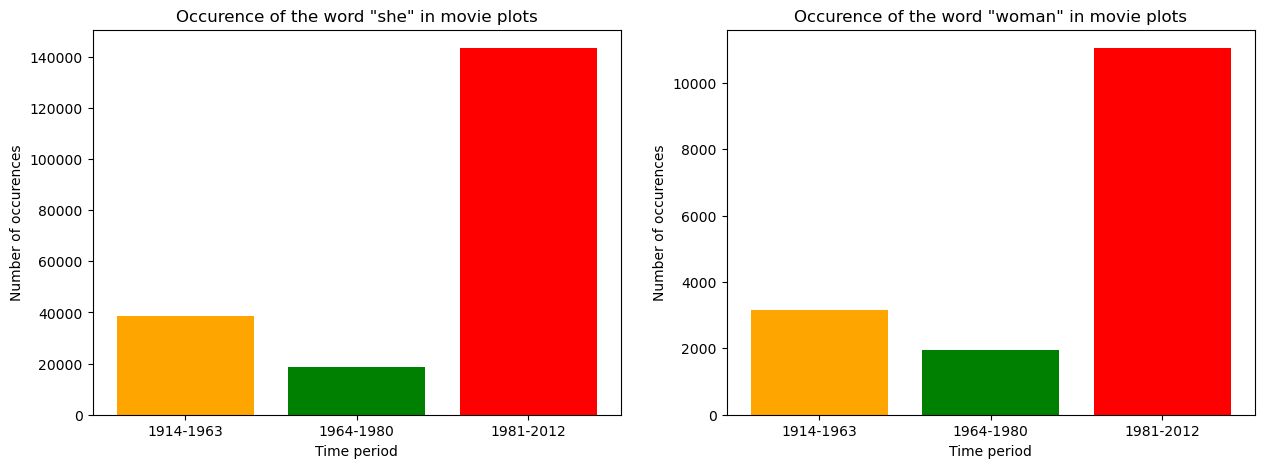

In [265]:
# Create 2 functions that computes the occurence of the word 'she', 'woman' 
def count_she_occurrences(df):
    return df['Plot'].apply(lambda plot: plot.count('she')).sum()

def count_woman_occurrences(df):
    return df['Plot'].apply(lambda plot: plot.count('woman')).sum()


# Apply the 1st function to the three dataframes
count_1914_1963_she = count_she_occurrences(movie_1914_1963)
count_1964_1980_she = count_she_occurrences(movie_1964_1980)
count_1981_2012_she = count_she_occurrences(movie_1981_2012)


# Apply the 2nd function to the three dataframes
count_1914_1963_woman = count_woman_occurrences(movie_1914_1963)
count_1964_1980_woman = count_woman_occurrences(movie_1964_1980)
count_1981_2012_woman = count_woman_occurrences(movie_1981_2012)




#plot the results in a bar plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(['1914-1963', '1964-1980', '1981-2012'], [count_1914_1963_she, count_1964_1980_she, count_1981_2012_she],  color=['orange', 'green', 'red'])
axs[0].set_title('Occurence of the word "she" in movie plots')
axs[0].set_xlabel('Time period')
axs[0].set_ylabel('Number of occurences')
axs[0].set_label('Occurence of the word "she" in movie plots')


axs[1].bar(['1914-1963', '1964-1980', '1981-2012'], [count_1914_1963_woman, count_1964_1980_woman, count_1981_2012_woman], color=['orange', 'green', 'red'])
axs[1].set_title('Occurence of the word "woman" in movie plots')
axs[1].set_xlabel('Time period')
axs[1].set_ylabel('Number of occurences')
plt.show()

A significance increase in She and Woman occurence after the feminist movement

Here we remove stop words to see what the 10 occurent words 


In [266]:
#Plot the 10 most occuring words in the movie plots for each time period
#Remove the stopwords before plotting
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#download the stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alielguindi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [267]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Make sure to download the stopwords set from NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')


# Make sure to download the stopwords set from NLTK
import nltk
nltk.download('stopwords')

# Define your additional stopwords
additional_stopwords = {'her', 'him', 'his', 'hers', 'its', 'their', 'theirs', 'our', 'ours', 'your', 'yours', 'one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fifteen', 'get', 'however', 'back'}

def remove_stopwords_and_punctuation(col, df):
    # Create a union of the default NLTK stopwords list with your additional words
    extended_stop_words = set(stopwords.words('english')).union(additional_stopwords)
    
    # Define a translator to remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    
    # Function to clean words list, remove stopwords, punctuation, and filter out empty strings
    def clean_words(words_list):
        cleaned_list = [word.lower().translate(translator) for word in words_list]
        # Filter out stopwords and empty strings
        return [word for word in cleaned_list if word not in extended_stop_words and word]

    # Apply cleaning function to the DataFrame
    df[col + '_cleaned'] = df[col].apply(clean_words)
    
    
    
    return df




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alielguindi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alielguindi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alielguindi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [268]:
#Apply the function to the three dataframes
cleaned_movie_1914_1963 = remove_stopwords_and_punctuation('Plot', movie_1914_1963)
cleaned_movie_1964_1980 = remove_stopwords_and_punctuation('Plot', movie_1964_1980)
cleaned_movie_1981_2012 = remove_stopwords_and_punctuation('Plot', movie_1981_2012)

/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_87178/983602085.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_cleaned'] = df[col].apply(clean_words)
/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_87178/983602085.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_cleaned'] = df[col].apply(clean_words)
/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_87178/983602085.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [269]:
from collections import Counter
# Define a function to get the top 10 most common words
def get_top_words(df):
    # Flatten the list of lists to a single list
    all_words = [word for sublist in df['Plot_cleaned'] for word in sublist]

    # Count the frequencies of words
    word_freq = Counter(all_words)

    # Select the top 10 most common words
    top_words = word_freq.most_common(10)

    return top_words


# Define a function to plot the top words
def plot_subplots(top_words_list, titles):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, top_words in enumerate(top_words_list):
        words, counts = zip(*top_words)
        axes[i].bar(words, counts)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Words')
        axes[i].set_ylabel('Frequency')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()





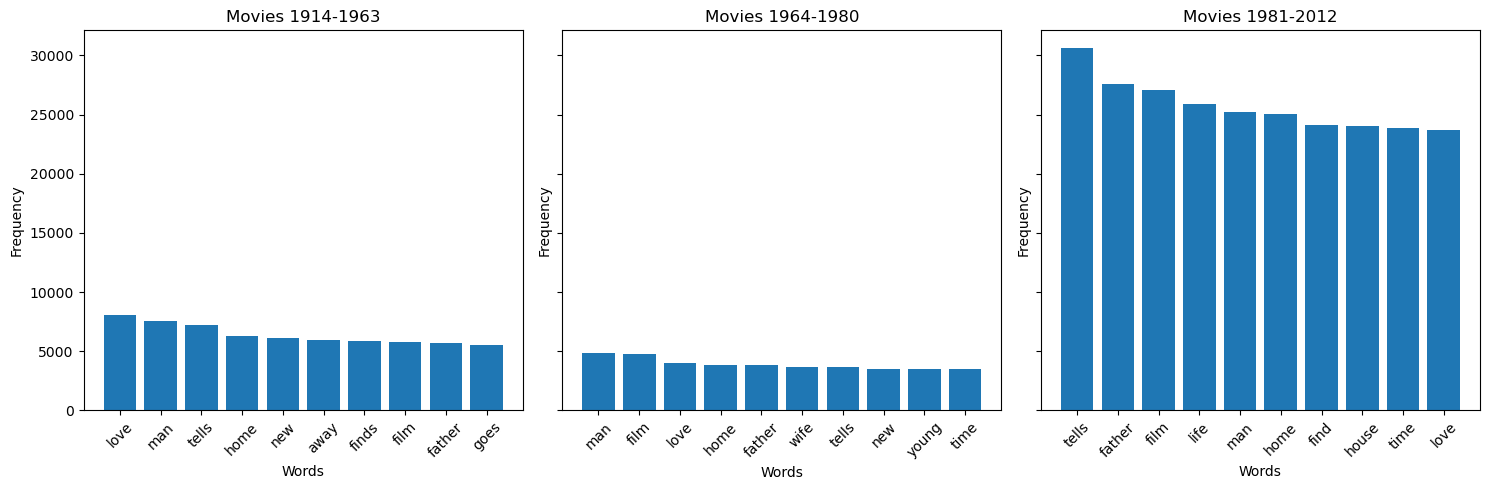

In [270]:
# Call the function to plot the top words

# Get the top words for each DataFrame
top_words_1914_1963 = get_top_words(cleaned_movie_1914_1963)
top_words_1964_1980 = get_top_words(cleaned_movie_1964_1980)
top_words_1981_2012 = get_top_words(cleaned_movie_1981_2012)

plot_subplots(
    [top_words_1914_1963, top_words_1964_1980, top_words_1981_2012],
    ['Movies 1914-1963', 'Movies 1964-1980', 'Movies 1981-2012']
)

* Pre-Feminist Movement (1914-1963): The most frequent words here include "love," "man," "tells," "home," "new," "finds," "film," "father," and "goes." These words suggest a focus on personal relationships, family, and possibly traditional gender roles, with "father" being more prominent than "mother" or other female roles.

* During the Feminist Movement (1964-1980): The words "man," "film," "father," "wife," "tells," "new," "young," and "time" are most frequent. The appearance of "wife" alongside "father" and "man" might indicate an increased attention to women's roles within the family and society. However, the data doesn't show a strong shift toward a more diverse range of female-oriented terms.

* Post-Feminist Movement (1981-2012): The words "tells," "film," "life," "man," "home," "find," "house," "time," and "love" are frequent. The presence of "life" and "house" alongside "home" and "love" could suggest that plots have become more varied, possibly reflecting a broader array of experiences and settings. Yet, there is no obvious increase in female-centric terms, which could imply that while there may be more stories about women's lives, the language used in summaries hasn't dramatically shifted to reflect feminist perspectives.

